# **League of Legends Ward Correlation Analysis**

**Name(s)**: Jacob Doan, Vanessa Feng

**Website Link**: (https://j2doan.github.io/LeagueofLegends/)

In [82]:
# Add utils to system path so we can import from there
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))

# Required Imports
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

# Additional Imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## **Introduction**

**League of Legends (LoL)** is a highly strategic, team-based game in which two teams of five players compete to destroy the opposing team’s base. Success can be influenced not only on individual skill but also on factors like map control, resource management, and coordinated teamwork.

For this project, we are going to analyze match data from Oracle’s Elixir, a premier database for professional LoL esports stats, covering the 2024 competitive season. The dataset includes match outcomes and detailed statistics such as kills, deaths, assists, team gold, dragons secured, towers destroyed, and advanced vision metrics like wards placed and wards cleared.

Our primary research questions focus on the **impact of objective control and vision control on win rates**. For example, we wondered: How does objective control influence win rates? How much can vision control influence win rates? Are there particular metrics that are especially predictive of success? Eventually, we decided to explore the following question further:
**What is the optimal number of wards placed per minute (WPM) that maximizes a team’s probability of winning?**

In LoL, wards are vision tools used to reveal parts of the map, helping teams track enemy movements and avoid ambushes. While strong vision control is generally viewed as beneficial, it's unclear whether more warding always leads to better outcomes. Excessive warding may lead to resource inefficiencies, while too little can compromise map awareness.

By analyzing the relationship between WPM (wards placed per minute) and match outcomes, we aim to identify whether there's an optimal rate for WPM that most effectively contributes to winning — and if there's a point where additional warding yields diminishing returns.

Here, we will take a first look at our only dataset: A League of Legends esports match data taken from OracleElixir during 2024.

In [48]:
df = pd.read_csv('../data/2024_LoL_esports_match_data_from_OraclesElixir.csv')
df

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_27292\2444245145.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,...,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,complete,NaN,KeSPA,...,2.0,0.0,5.0,2.0
117646,LOLTMNT02_194401,complete,NaN,KeSPA,...,7.0,7.0,9.0,8.0
117647,LOLTMNT02_194401,complete,NaN,KeSPA,...,8.0,8.0,16.0,7.0


This dataset seems quite impressive. There are 117647 rows, meaning that many entries reprsenting a player during a specific match. More importantly, there seems to be a lot of columns... **161** to be exact. Most of these columns are irrelevant at this stage of investigating our question, so we will include only examine, clean, and plot the relevant columns for now for a better understanding.

With a simple for loop:

```
for i in df.columns:
    print(i)
```

Upon a manual inspection, some columns appear to be relevant:

1. **`gameid`** (string): the id of the match that two teams played in against each other.
2. **`playerid`** (string): the player on that team for the current match.
3. **`teamid`** (string): the id of the team that played in that match.
4. **`wardsplaced`** (int): the total number of wards placed by everyone in that team for the entire match.
5. **`gamelength`** (int): the number of seconds that the match took.
6. **`wpm`** (float): the rate of number of wards placed per minute.
  - Note: this column was already given to us.
  - However, a person can get a similar value by converting the gamelength value into minutes, and then dividing wardsplaced by gamelength in minutes.
  - Example: 1886 seconds * 60 = 31.43 minutes.
  - 14 wards placed / 31.43 minutes = 0.45 wards placed per minute
7. **`result`** (int): whether a team won that match. 1 represents a win, 0 reprsents a loss.

In [49]:
relevant_df = df[['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]
relevant_df

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,oe:player:3126bca5d4d2555ba3b460699508e16,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,81,2546,1.91,1
117646,LOLTMNT02_194401,NaN,oe:team:2a247555001e6364757f171f158f997,146,2546,3.44,0
117647,LOLTMNT02_194401,NaN,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,158,2546,3.72,1


## **Data Cleaning and Exploratory Data Analysis**

We can start cleaning this data frame by ensuring the following:

1. We must verify that wardsplaced, gamelength, and wpm are all greater than or equal to 0.
  - This is because there cannot be a negative number of wards placed in a game, the minimum is 0.
  - Likewise a game must last at least greater than 0 seconds. This makes sense intutively, and also because to calculate wpm, we cannot divide by 0.
  - And finally, wpm, representing a proportion, cannot be negative.
2. We must verify that all wpm is an accurate reprsentation of the wardsplaced and gamelength columns.
  - This means we must check whether wpm = wardsplaced / (gamelength / 60)
3. We must verify that the results column consists of either only 1s or 0s
  - Anything other than that would be incorrect, as it wouldn't represent a win or loss.

On a side note, we are leaving gameid, playerid, and teamid alone for now. They are strings with no inherent restrictions on them, unlike the columns with numerical representation of certain values. Even if there is missing data, we will address them in a later section.

In [50]:
print(np.all((relevant_df['wardsplaced'] >= 0)))
print(np.all((relevant_df['gamelength'] >= 0)))
print(np.all((relevant_df['wpm'] >= 0)))
recalculated_wpm = relevant_df['wardsplaced'] / (relevant_df['gamelength'] / 60)
print(np.all(np.isclose(recalculated_wpm, relevant_df['wpm'], atol=0.01)))
print(relevant_df['result'].isin([0, 1]).all())

True
True
True
True
True


It seems like there are no incorrectly formatted data within our relevant dataset that needs to be corrected at this time. This means out dataset was already given to us clean. Thank goodness!

Before, we can begin aggregating this dataframe, we need to understand the influence of the column playerid. Let's take a snippet of just ONE game for example. We will use gameid `10660-10660_game_1` for this demonstration.

In [51]:
df[df['gameid'] == '10660-10660_game_1'][['gameid', 'playerid', 'teamid', 'wardsplaced', 'gamelength', 'wpm', 'result']]

,gameid,playerid,teamid,wardsplaced,gamelength,wpm,result
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,1886,0.45,0
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,1886,0.32,0
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,1886,0.13,0
...,...,...,...,...,...,...,...
9,10660-10660_game_1,oe:player:937dc5479c6416d1ad4997538144f6e,oe:team:8516ca63facc91286d6c00212ca945e,76,1886,2.42,1
10,10660-10660_game_1,NaN,oe:team:a9145b7711873f53e610fbba0493484,97,1886,3.09,0
11,10660-10660_game_1,NaN,oe:team:8516ca63facc91286d6c00212ca945e,122,1886,3.88,1


Notice how each row represents a PLAYER'S statistics. Our goal is to find the optimal wards placed per minute by TEAM overall. Each player on a team has different roles, so naturally some players may place a different rate of wpm than others depending on how much they are supposed to support the team.

Thus, we will groupby the relevant dataframe to show us each team's average wpm, and whether they won or lost, in a specific game.

Note: if a team won or lost, then all players in their team should share the same result value. Thus, results can only be a 1 or 0.

In [52]:
grouped = relevant_df.groupby(['gameid', 'teamid']).agg({
    'wpm': 'mean',
    'result': 'mean'
}).reset_index()

# do this because groupby mean causes it to become a float
grouped['result'] = grouped['result'].astype(int)

grouped

,gameid,teamid,wpm,result
0,10660-10660_game_1,oe:team:8516ca63facc91286d6c00212ca945e,1.29,1
1,10660-10660_game_1,oe:team:a9145b7711873f53e610fbba0493484,1.03,0
2,10660-10660_game_2,oe:team:8516ca63facc91286d6c00212ca945e,1.21,1
...,...,...,...,...
19153,LOLTMNT99_148130,oe:team:5203ff881d5c82c5f720eb3a2f3b44c,0.97,1
19154,LOLTMNT99_148194,oe:team:1bcba9d314932379a955b3de9e8654d,1.34,0
19155,LOLTMNT99_148194,oe:team:28428f3022fc1ea52264b35912093dc,1.21,1


We can double check this to make sure.

In [53]:
print(grouped['result'].isin([0, 1]).all())

True


This looks way more organized! Let's perform a univarate analysis just to visualize the distribution of wpm, regardless of whether a team won or lost.

wpm being a proportion makes itself a continuous variable, unlike wardsplaced or gamelength which are represented by discrete values. So, we will be visualizing these distributions with a KDE plot

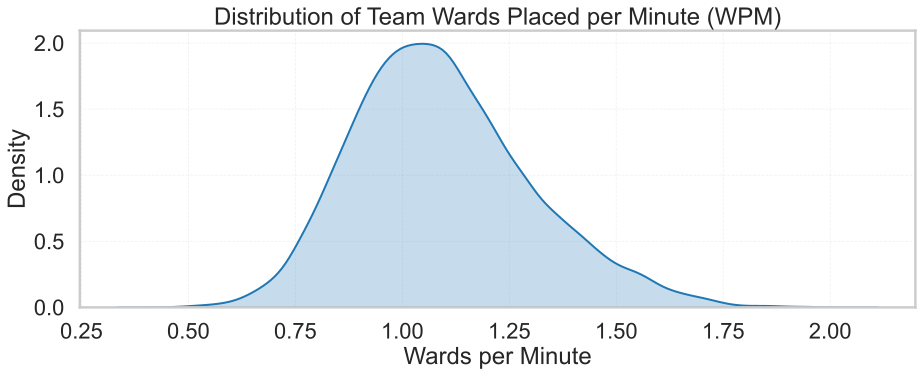

In [54]:
plt.figure(figsize=(15, 5))
sns.kdeplot(grouped['wpm'], fill=True)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

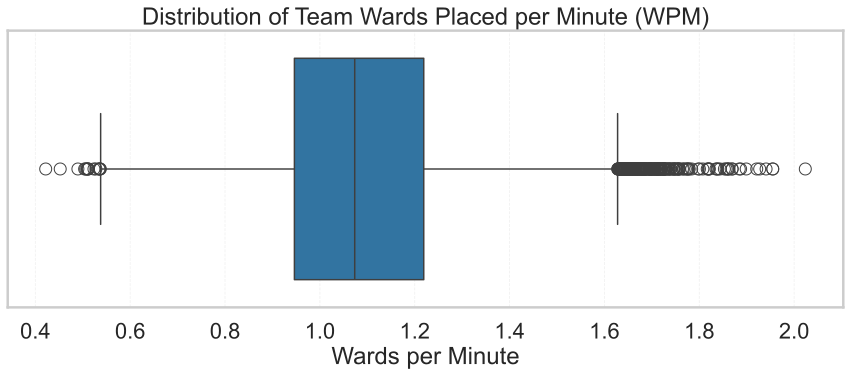

In [55]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=grouped['wpm'], linewidth=1.5)
plt.title("Distribution of Team Wards Placed per Minute (WPM)")
plt.xlabel("Wards per Minute")
plt.yticks([])
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.show()

Now, let's see if there is a glaring difference at first sight between the wdm of teams that won, and the wdm of teams that lost.

In [56]:
wpm_win = grouped[grouped['result'] == 1]['wpm']
wpm_loss = grouped[grouped['result'] == 0]['wpm']

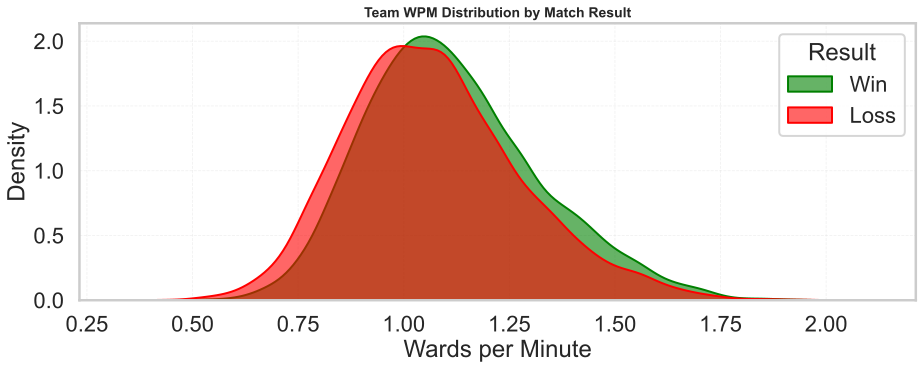

In [ ]:
plt.figure(figsize=(15, 5))

sns.kdeplot(wpm_win, fill=True, label='Win', color='green', alpha=0.6, linewidth=2)
sns.kdeplot(wpm_loss, fill=True, label='Loss', color='red', alpha=0.6, linewidth=2)

plt.title("Team WPM Distribution by Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards placed per Minute")
plt.ylabel("Density")
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
plt.legend(title="Result", loc="upper right")
plt.show()

As for the boxplot, we need to add an extra column called result_str, because Seaborne expects the palette keys to exactly match the unique values in the y='result' column, and if they don’t, it raises a ValueError. To prevent possible errors, we will make this new column and map it to the boxplot.

C:\Users\Jacob Doan\AppData\Local\Temp\ipykernel_27292\585939008.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



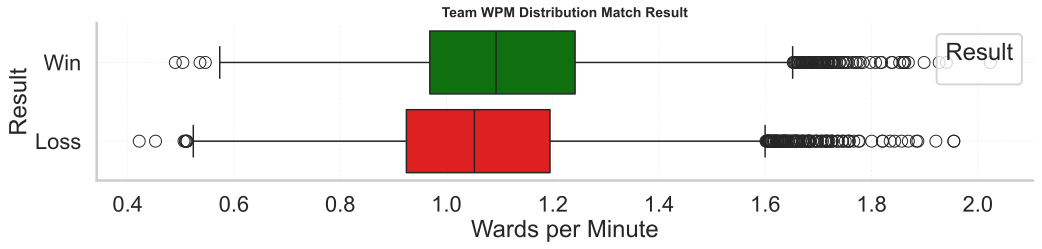

In [ ]:
grouped['result_str'] = grouped['result'].map({1: 'Win', 0: 'Loss'})

plt.figure(figsize=(15, 4))

sns.boxplot(
    data=grouped,
    x='wpm',
    y='result_str',
    hue='result_str',
    palette={'Win': 'green', 'Loss': 'red'},
    linewidth=1.5,
    dodge=False
)

plt.title("Team WPM Distribution Match Result", fontsize=14, fontweight='bold')
plt.xlabel("Wards placed per Minute")
plt.ylabel("Result")
plt.legend(title='Result', loc='upper right')
plt.grid(visible=True, linestyle='--', linewidth=0.8, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

Before we continue, let's change the variable name of our dataframe to `wards_df` because it sounds more meaningful than `grouped`. We will refer to `wards_df` from this point on.

In [59]:
wards_df = grouped
wards_df

,gameid,teamid,wpm,result,result_str
0,10660-10660_game_1,oe:team:8516ca63facc91286d6c00212ca945e,1.29,1,Win
1,10660-10660_game_1,oe:team:a9145b7711873f53e610fbba0493484,1.03,0,Loss
2,10660-10660_game_2,oe:team:8516ca63facc91286d6c00212ca945e,1.21,1,Win
...,...,...,...,...,...
19153,LOLTMNT99_148130,oe:team:5203ff881d5c82c5f720eb3a2f3b44c,0.97,1,Win
19154,LOLTMNT99_148194,oe:team:1bcba9d314932379a955b3de9e8654d,1.34,0,Loss
19155,LOLTMNT99_148194,oe:team:28428f3022fc1ea52264b35912093dc,1.21,1,Win


## **Assessment of Missingness**

When we initially created the `ward_df` DataFrame (previously referred to as `grouped`), we made a critical design choice during aggregation: we excluded rows with missing values in teamid. Our reasoning at the time was practical: including incomplete team data could distort the distributions of key metrics like wards placed per minute (wpm) or match outcomes (result). For example, if a team disconnected mid-match or was partially recorded, its statistics might not reflect actual gameplay and could **introduce noise or bias** into our analysis.

However, this decision raises an important question: **was the missingness of teamid random, or was it systematically related to other variables in our dataset?** If it was not random (NMAR), then excluding those rows — even for good reasons — could unintentionally bias our results, since there is probably a good reason why those team ids are missing that we haven't seen clearly yet. 

In our earlier cleaning steps, we focused on ensuring that quantitative columns like wpm, result, and wardsplaced contained no missing values. We did not yet explore missingness in columns as `gameid`, `playerid`, and `teamid`, because of their irrelevance to aggregating the data at the time. Now, as we transition to a deeper analysis of missing data, we will revisit the full `relevant_df` and `df` to formally investigate the missingness mechanisms behind `teamid` and how they might affect our conclusions.

In [60]:
relevant_df.isnull().sum()

gameid             0
playerid       20660
teamid          2712
wardsplaced        0
gamelength         0
wpm                0
result             0
dtype: int64

It seems like only `playerid` and `teamid` has missing values. Let's analyze `playerid` first before we move on.

At first glance, the column `playerid` appears to be Not Missing At Random (NMAR). There are several reasons to suspect this.

First, there are many more missing `playerid` values than there are missing `teamid` values. So implies that `playerid` can be **missing independently of `teamid`** — which is important context. Moreover, many rows with missing `playerid` still contain a valid `teamid` and complete gameplay statistics — such as `wardsplaced`, `wpm`, and `result`. This suggests that the missingness is not tied to overall data corruption completely, but rather it could be to the identity of the player itself.

**Without additional context**, it seems the missingness can be tied to the player's identity itself. Examples that could explain this could be due to data privacy settings, untracked players, or deleted accounts. These are unobservable from within the dataset, which fits the definition of NMAR.

However, it is important to note that we are only basing our conclusion given only the column context within `wards_df`. If we were to incorporate broader metadata from the full dataset, such as datacompleteness, league, or split, we might find patterns that explain the missingness of `playerid`. For example, matches flagged as "partial" in the column `datacompleteness` may be systematically missing player identity information. In that case, the missingness could be modeled by observed variables, and `playerid` would instead be considered Missing At Random (MAR).

Thus, our conclusion is that `playerid` is NMAR without additional context outside of `relevant_df`, but it could be MAR when we incorporate metadata from the full dataset.

Next, we will explore the missingness of `teamid`.

Unlike playerid, `teamid` is central to our primary research question: how **team-level statistics** like wpm relate to winning. This makes its missingness more **consequential** — if rows with missing teamid differ systematically, their exclusion could bias our analysis. In other words, it really doesn't matter what type of missingness `playerid` has, since the objective of our main analysis does not care for it. That column was only supposed to give us a visual representation of how each team has multiple rows of data that needed to be aggregated into. The more imporant column of interst is `teamid`

While teamid also has missing values in **relevant_df**, we realized that to properly investigate its missingness mechanism, we needed to go beyond **relevant_df**. Many of the variables such as match-level metadata like `datacompleteness` were likely to explain its absence. Othe arbitrary gameplay statistics like `earnedgpm` could also be analyzed in context too, but these columns were only available in the original full dataset (df).

Therefore, we extended our analysis and performed permutation tests using variables from the full dataset. Our goal was to determine whether the missingness of `teamid` is Missing Completely At Random (MCAR), Missing At Random (MAR), or potentially NMAR. If the missingness can be explained by known columns, it would support a MAR classification and justify our earlier decision to drop rows with missing teamid in `wards_df` (aka `grouped`). If not, we would need to re-evaluate our cleaning pipeline.

The following permutation tests evaluate whether `teamid` missingness depends on observed columns.

Our hypothesis is that `teamid` is Missing At Random (MAR), because it would justify our decision to remove those missing rows. To test this, we examined whether the missingness of teamid depends on:

- Another column in `df` that should be related (like `datacompleteness`, since if the data is only partially complete is missing, we might expect teamid to be incomplete)

- Another column in `df` that should not be related (like earnedgpm, since earned gold per minute shouldn't logically influence whether a team's name is recorded or not)

We conducted permutation tests to investigate whether the distributions of these variables change depending on whether teamid is missing or not. The basic idea of these permutaion tests is to get evidence that if our p-value is low, then the column is likely MAR. If it is not low, then the column is likely MCAR. Below, we present and interpret our results. We set our alpha threshold at standard 0.05.

**Note: We have to be careful on which columns we select to test!** If the column we are testing against also has missing values that overlap with teamid, then our permutation test can give artificially low p-values, not because there's a true association. This is because both columns could be missing in the same rows. We can  find which columns to pick using code.

In [61]:
# Here, we manually picked which columns without missing data might be good to compare against in a permutation test
df.isnull().sum()[df.isnull().sum() <= 0]

gameid              0
datacompleteness    0
league              0
                   ..
earned gpm          0
goldspent           0
monsterkills        0
Length: 35, dtype: int64

In [62]:
relevant_df_copy = relevant_df.copy()

relevant_df_copy['teamid_missing'] = relevant_df_copy['teamid'].isnull()
relevant_df_copy['playerid_missing'] = relevant_df_copy['playerid'].isnull()

relevant_df_copy

,gameid,playerid,teamid,wardsplaced,...,wpm,result,teamid_missing,playerid_missing
0,10660-10660_game_1,oe:player:65ed20b21e2993fb00dbd21a2fd991b,oe:team:a9145b7711873f53e610fbba0493484,14,...,0.45,0,False,False
1,10660-10660_game_1,oe:player:57da8dfcfbdb4e5b019fe93003db1c4,oe:team:a9145b7711873f53e610fbba0493484,10,...,0.32,0,False,False
2,10660-10660_game_1,oe:player:71e79ef80600d398d90cfebe3b0b758,oe:team:a9145b7711873f53e610fbba0493484,4,...,0.13,0,False,False
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,oe:player:3126bca5d4d2555ba3b460699508e16,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,81,...,1.91,1,False,False
117646,LOLTMNT02_194401,NaN,oe:team:2a247555001e6364757f171f158f997,146,...,3.44,0,False,True
117647,LOLTMNT02_194401,NaN,oe:team:66eccb6faca7fd5e3cdf4ccf903385c,158,...,3.72,1,False,True


In [63]:
# it seems about 2.3% of our teamid column has missing values
relevant_df_copy['teamid_missing'] = relevant_df_copy['teamid'].isnull()
relevant_df_copy['teamid_missing'].value_counts()

teamid_missing
False    114936
True       2712
Name: count, dtype: int64

In [64]:
def pass_test(p_val):
    if p_val < 0.05:
        return f"P-value: {p_val:.4f}, reject the null hypothesis."
    else:
        return f"P-value: {p_val:.4f}, fail to reject the null hypothesis."

Now, let's start the permutation tests for `earned gpm` and `datacompleteness`

In [97]:
relevant_df_copy['earned gpm'] = df['earned gpm']

# Setting up observed difference
obs_diff_gpm_df = relevant_df_copy.groupby('teamid_missing')['earned gpm'].mean()

obs_diff_gpm = obs_diff_gpm_df.loc[True] - obs_diff_gpm_df.loc[False]

# Permutation test
n_reps = 1000
diffs = []

for _ in range(n_reps):
    shuffled = np.random.permutation(relevant_df_copy['teamid_missing'])
    shuffled_df = relevant_df_copy.assign(shuffled_teams1=shuffled)
    
    group_means = shuffled_df.groupby('shuffled_teams1')['earned gpm'].mean()
    diff = group_means.loc[True] - group_means.loc[False]
    diffs.append(diff)

# Plot results
fig = go.Figure()
fig.add_trace(go.Histogram(x=diffs, nbinsx=50, name='Permuted Differences'))
fig.add_vline(x=obs_diff_gpm, line_color='red', line_width=2, opacity=1)
fig.add_annotation(
    x=obs_diff_gpm,
    y=20,
    text='Observed Difference',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color='red')
)
fig.update_layout(
    title='Permutation Test: Earned GPM vs. TeamID Missingness',
    xaxis_title='Difference in Mean Earned GPM',
    yaxis_title='Frequency'
)
fig.show()

# Two-sided p-value
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff_gpm))
pass_test(p_val)

'P-value: 0.0890, fail to reject the null hypothesis.'

In [98]:
relevant_df_copy['datacomplete_binary'] = df['datacompleteness'].map({'complete': 0, 'partial': 1})

# Setting up observed difference
obs_diff_complete_df = relevant_df_copy.groupby('teamid_missing')['datacomplete_binary'].mean()

obs_diff_complete = obs_diff_complete_df.loc[True] - obs_diff_complete_df.loc[False]

# Permutation test
n_reps = 1000
diffs = []

for _ in range(n_reps):
    shuffled = np.random.permutation(relevant_df_copy['teamid_missing'])
    shuffled_df = relevant_df_copy.assign(shuffled_teams2=shuffled)
    
    group_means = shuffled_df.groupby('shuffled_teams2')['datacomplete_binary'].mean()
    diff = group_means.loc[True] - group_means.loc[False]
    diffs.append(diff)

# Plot results
fig = go.Figure()
fig.add_trace(go.Histogram(x=diffs, nbinsx=50, name='Permuted Differences'))
fig.add_vline(x=obs_diff_complete, line_color='red', line_width=2, opacity=1)
fig.add_annotation(
    x=obs_diff_complete,
    y=20,
    text='Observed Difference',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color='red')
)
fig.update_layout(
    title='Permutation Test: Data Completeness vs. TeamID Missingness',
    xaxis_title='Difference in Mean Data Completeness',
    yaxis_title='Frequency'
)
fig.show()

# Two-sided p-value
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff_complete))
pass_test(p_val)

'P-value: 0.0000, reject the null hypothesis.'

After running our permutation tests:

The p-value for `earnedgpm` was above 0.05, which is not statistically significant at α = 0.05, suggesting we found at least one column without a meaningful relationship between missingness of teamid and gold earned per minute. This is a gameplay statistic unrelated to data collection quality.

The p-value for `datacompleteness` was below 0.05, indicating a strong relationship between whether a row has a missing teamid and whether the match was flagged as "complete" or "partial."

These results rule out MCAR (Missing Completely At Random) for `teamid`, because at least one observed column (`datacompleteness`) does explain the missingness. This supports the interpretation that teamid is Missing At Random (MAR). The probability of teamid being missing is highly related to other observed variables in the dataset (like metadata about match completeness), but not to unobservable factors.

Since the missingness is explainable by observed data, we can conclude that `teamid` does not have an NMAR missingness mechanism, and thus our earlier choice to drop rows with missing teamid is justified. Doing so likely does not introduce bias into our core analysis of WPM vs. win rate, because the mechanism driving the missingness is not related to the values of the statistics we're analyzing (like `earnedgpm` or `wpm`), but to data quality flags.

In contrast, we cannot make the same claim for `playerid` (as discussed previously), which may be NMAR due to factors that are not observable in the current context (`relevant_df`). Fortunately, since playerid is not central to our analysis, this does not impact the validity of our conclusions.

## **Hypothesis Testing**

To determine whether teams that place more wards per minute are more likely to win, we will now conduct a permutation test on `wards_df`. We will use a permutation test because we are trying to determine whether our two "samples" (the mean wpm from winners, and the mean wpm from the losers) were drawn from the same population. In other words, are those distributions similar by chance?

We formally define our null, alternative hypothesis, test statistic, and significance level as below:

**Null Hypothesis (H₀)**: There is no relationship between a team's average Wards Placed per Minute (WPM) and their probability of winning. Any observed difference in average WPM between winning and losing teams is due to chance.

**Alternative Hypothesis (Hₐ)**: Teams that win have higher average WPM than teams that lose. In other words, warding (as measured by WPM) is positively associated with win rate.

**Test Statistic**: The difference in mean WPM between winning teams and losing teams. We chose this because we needed a test statistic that can measure how different two numerical distributions are (i.e. wpm from winners vs wpm from losers)

**Significance Level**: 0.05

In [67]:
mean_win = wards_df[wards_df['result'] == 1]['wpm'].mean()
mean_loss = wards_df[wards_df['result'] == 0]['wpm'].mean()
obs_diff = mean_win - mean_loss

print("Mean WPM (Win):", mean_win)
print("Mean WPM (Loss):", mean_loss)
print("Observed Difference:", obs_diff)

Mean WPM (Win): 1.1160762595287594
Mean WPM (Loss): 1.070521721196868
Observed Difference: 0.04555453833189138


In [99]:
wards_df_copy = wards_df.copy()

n_permutations = 1000
diffs = []
for _ in range(n_permutations):
    shuffled = np.random.permutation(wards_df_copy['result'])
    shuffled_df = wards_df_copy.assign(shuffled_result=shuffled)

    group_means = shuffled_df.groupby('shuffled_result')['wpm'].mean()
    diff = group_means.loc[1] - group_means.loc[0]
    diffs.append(diff)

# Plot results
fig = go.Figure()
fig.add_trace(go.Histogram(x=diffs, nbinsx=50, name='Permuted Differences'))
fig.add_vline(x=obs_diff, line_color='red', line_width=2, opacity=1)
fig.add_annotation(
    x=obs_diff,
    y=20,
    text='Observed Difference',
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(color='red')
)
fig.update_layout(
    title='Permutation Test: Mean WPM vs. Result',
    xaxis_title='Difference in Mean WPM',
    yaxis_title='Frequency'
)
fig.show()

# Calculate p-value
p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))
pass_test(p_value)

'P-value: 0.0000, reject the null hypothesis.'

Our permutation test yielded a p-value approximately equal to 0.00, that we reject the null hypothesis. We conclude that teams that win have a higher average wpm than teams that lose. 

In hindsight, this also makes sense intuitively. First, through a statistical perspective, although the visualiztion showed the distributions of mean_wpm from winners vs losers to be very similar, we have to account for the sheer size of the dataset. There are **19156** entries in `wards_df`. Even if the two distributions overlap a lot, the sheer size of our dataset (tens of thousands of games) increases our test's power. This can make even a small mean differences become detectable, and thus seem statistically significant.

Warding is a key strategic element in LoL. Teams that place more wards should, and now we confidently believe with evidence, gain better vision control, allowing them to track enemy movements, avoid ambushes, and secure objectives more effectively. This would increase the chances of winning. Therefore, it is expected that winning teams have consistently higher warding activity.

Hence, the extremely low p-value reflects a strong and consistent pattern: teams that ward more frequently are more likely to win, confirming the importance of vision control in LoL success.


## **Framing a Prediction Problem**

**Our goal is to predict whether a team wins a LoL match, given also other in-game features related to `wpm`, such as `side`, `position`, `vision score`, and of course, `wpm`.**

This is a **binary classification model**, where the response variable is `win` (1 for win, 0 for lose).
We will evaluate our models using accuracy, as our dataset is approximately balanced between the two classes.
Accuracy is appropriate in this context because it measures the proportion of correct predictions, which directly answers our modeling question.
If we find the classes are imbalanced, we will additionally report the F1-score to account for differences in precision and recall.
All features used in our model are available prior to the end of the match. We will not use any information that could reveal the outcome before prediction time.
Our modeling process follows a standard, reproducible pipeline:

1. Train/Test Split
We will split the data into training and test sets to separate model fitting from final evaluation.

2. Preprocessing and Pipeline
We will use ColumnTransformer and Pipeline to apply preprocessing (e.g., encoding categorical variables and scaling numeric ones) consistently across cross-validation and the final model.

3. Cross-Validation and Hyperparameter Tuning
We will apply grid search with cross-validation to tune model hyperparameters using only the training data.

4. Final Evaluation
After selecting the best model, we will evaluate its generalization performance on the held-out test set, which is only used once to report final metrics.

## **Baseline Model**

From now on, we need to approach this section with a different dataframe called `df_model`. The original dataframe `wards_df` showcased aggregated data that was appropriate for conducting the permutation tests in previous sections. However, our prediction problem demands us to use other features outside of `wards_df`. So here, we use `df_model`, a filtered version of the full dataset containing only complete observations, to train and evaluate a classification model.

This dataset allows us to include richer in-game features — such as:

1. **`side`** (str): which side the team was on ('Blue' or 'Red')
2. **`position`** (str): referring to team role or lane assignments..
3. **`wpm`** (float): the rate of number of wards placed per minute.
4. **`vspm`** (float): the rate of vision score per minute.

**Quantitative features**: 2

- *Discrete features*: 0 (none of our features were produced by counting)
- *Continuous features*: 2 (wpm and vspm)

**Categorical features**: 2

- *Ordinal features*: 0 (none of our features have a meaningful order, like ranks or ratings)
- *Nominal features*: 2 (side and position)

The goal is to predict the result (1 = win, 0 = loss), based on these features. 

In [69]:
df_model = df.query("datacompleteness == 'complete'")
df_model

,gameid,datacompleteness,url,league,...,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
180,LOLTMNT99_132542,complete,NaN,TSC,...,1.0,1.0,1.0,3.0
181,LOLTMNT99_132542,complete,NaN,TSC,...,1.0,2.0,3.0,2.0
182,LOLTMNT99_132542,complete,NaN,TSC,...,3.0,1.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...
117645,LOLTMNT02_194401,complete,NaN,KeSPA,...,2.0,0.0,5.0,2.0
117646,LOLTMNT02_194401,complete,NaN,KeSPA,...,7.0,7.0,9.0,8.0
117647,LOLTMNT02_194401,complete,NaN,KeSPA,...,8.0,8.0,16.0,7.0


In [70]:
df_model['result']

180       1
181       1
182       1
         ..
117645    1
117646    0
117647    1
Name: result, Length: 100956, dtype: int64

We decided to build our model using only entries where the data is fully complete, as indicated by the `datacompleteness` column. This choice is based on prior analysis in a previous section, showing that some missing values in the dataset (e.g. `teamid`) are not missing at random. Including such rows could introduce **unwanted bias or noise** into the model. To avoid this, we filtered the dataset to retain only rows where `datacompleteness` == 'complete'.

For context, two of our input features: `side` and `position`, are categorical. To use them effectively in our model, we applied one-hot encoding, which converts each category into a binary feature. This allows categorical variables to be represented numerically and interpreted correctly by the model. The other features of interest, `wpm` and `vspm`, were already numerical. They were passed through without transformation.

We implemented this preprocessing using a ColumnTransformer, which applies different transformations to different feature types, and wrapped it into a pipeline for a clean and modular modeling workflow.

We followed a standard supervised learning workflow:

1. **Train/Test Split**:
We split the data into training and test sets using an 80/20 split, with stratify=y to preserve the class balance in both sets. This ensures that the distribution of wins and losses remains consistent across the training and testing partitions.

2. **Preprocessing**:
Since side and position are categorical variables, we **one-hot encode** them (dropping the first category to avoid multicollinearity). The numeric features (wpm, vspm) are passed through without transformation.

3. **Baseline Model — Decision Tree**:
We use a Decision Tree Classifier as our baseline model. The reason for using a decision tree is because **our predictive column `result` has binary representations(**. 1 = win, 0 = lose. So naturally, decision trees would be perfect for this job, because it is interpretable model that often serves as a good starting point in **binary classification tasks**.

4. **Pipeline**:
We combine preprocessing and modeling into a single Pipeline using make_pipeline, which helps ensure clean, repeatable transformations during both training and evaluation.

In [71]:
features = ['side', 'position', 'wpm', 'vspm']
target = 'result'

X = df_model[features]
y = df_model[target]

#Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=80, stratify=y
)

#one-hot encode categorical, pass through numerical columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), ['side', 'position']),
    remainder='passthrough'
)

#pipeline
baseline_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=80)
)

#fit the model
baseline_pipeline.fit(X_train, y_train)

#evaluate, delete these # when youre done, theyre here so u can find stuff better!
y_pred = baseline_pipeline.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_precision = precision_score(y_test, y_pred)
baseline_recall = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {baseline_accuracy:.3f}")
print(f"Precision: {baseline_precision:.3f}")
print(f"Recall: {baseline_recall:.3f}")
print(f"F1-score: {baseline_f1:.3f}")

Accuracy: 0.538
Precision: 0.538
Recall: 0.535
F1-score: 0.537


**Summary**:

- **Accuracy**: 0.538, overall correctness
- **Precision**: 0.538, how often predicted wins are correct
- **Recall**: 0.535, how many actual wins were caught
- **F1-score**: 0.537, a single score balancing precision & recall

Overall, the quality of our baseline model (without hyperparameter tuning) is subpar, but expected. Our goal here was to just establish a working model with limited features. There is definitely room for improvement.

## **Final Model**

To improve upon our baseline model, we expanded the feature set to include additional vision-related variables:

**`wardsplaced`** (int): total number of wards placed

**`visionscore`** (int): an integer representing a broader measure of vision contribution

**`controlwardsbought`** (int): how many control wards were purchased

Based on these descriptions, we believe that these variables are relevant to `wpm`, and therefore may provide a new insight on improving the predictions and quality of our model. **These features capture the overall investment in vision and may provide more information than just per-minute metrics.** After all, our prediction goal remains the same: to determine whether a team wins based on features like `wpm` and related statistics. Since vision is a valid aspect of strategic gameplay in LoL (as demonstrated in previous sections with wpm), we believe these variables can strengthen our model's ability to predict match outcomes. These new features will be combined with those from the baseline model (side, position, wpm, vspm) to form the complete `features_final` set.

We will also reuse the same splitting strategy as in the baseline model:

1. 80/20 split into training and testing sets
2. Stratified sampling to maintain the class balance
3. Fixed random seed for reproducibility

This ensures a fair comparison between the baseline and final models, so we can evaluate our attempt at improving this model.

In [76]:
features_final = ['side', 'position', 'wpm', 'vspm', 'wardsplaced', 'visionscore', 'controlwardsbought']
target = 'result'

X = df_model[features_final]
y = df_model[target]

# Split as before (use same random_state and stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80, stratify=y)

We have also updated our ColumnTransformer to accommodate the new feature types:

For more context about our features:

- `side` and `position` are **nominal categorical features**, and thus they need to be processed through one-hot encoding to get usable values (dropping first level)
- `wardsplaced`, `visionscore`, and `controlwardsbought` are discrete quantatative features; they need to be standardized using StandardScaler

The remaining numeric features (`wpm`, `vspm`) are passed through as-is.

We made this pipeline to ensure that preprocessing is applied consistently across both training and testing.

In [77]:
preprocessor_final = make_column_transformer(
    (OneHotEncoder(drop='first'), ['side', 'position']),
    (StandardScaler(), ['wardsplaced', 'visionscore', 'controlwardsbought']),
    remainder='passthrough'
)

For our final model, we continued using a **Decision Tree Classifier** due to its interpretability and ability to predict binary classifiers (i.e. `result`). However, unlike in the baseline model, we now perform **hyperparameter** tuning to improve the model's performance and avoid overfitting or underfitting.

The primary hyperparameter we want to tune is **max_depth**, which controls the maximum depth of the tree. We want to avoid a tree that is too shallow (which may underfit the model), and a tree that is too deep (which may overfit the model).

To find an appropriate depth, we use **GridSearchCV**, which performs an exhaustive search to find the optimal height/hyperparameter to use. In our case, we chose and tested five different depths: **[3, 5, 7, 10, 15]**.

To evaluate each option, we will use:

- A **5-fold cross-validation** (`cv=5`), which splits the training data into five parts and rotates the validation fold, ensuring a more reliable estimate of model performance

- **Accuracy as the scoring metric** (`scoring='accuracy'`), which aligns with our goal of maximizing correct predictions in a roughly balanced dataset

This process helps us select a model that generalizes well to new data by identifying the best tree depth in our given options.

In [78]:
#pipeline
final_pipeline = make_pipeline(preprocessor_final,DecisionTreeClassifier(random_state=80))

#grid search
param_grid = {'decisiontreeclassifier__max_depth': [3, 5, 7, 10, 15]}

search = GridSearchCV(final_pipeline, param_grid,cv=5, scoring='accuracy', n_jobs=-1)
search.fit(X_train, y_train)


c:\miniforge3\envs\dsc80\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['side',
                                                                          'position']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['wardsplaced',
                                                                          'visionscore',
                                                                          'controlwardsbought'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=80))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [3, 5, 7, 10,
                                                               15]},
             scoring='accuracy')

After fitting the model with GridSearchCV, we use the best-found model to make predictions on the held-out test set:

In [ ]:
y_pred_final = search.best_estimator_.predict(X_test)

Let's take a look at it's performance.

In [80]:
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"Accuracy: {final_accuracy:.3f}")
print(f"Precision: {final_precision:.3f}")
print(f"Recall: {final_recall:.3f}")
print(f"F1-score: {final_f1:.3f}")


Accuracy: 0.606
Precision: 0.601
Recall: 0.628
F1-score: 0.615


Let's also create a confusion matrix to visualize these results.

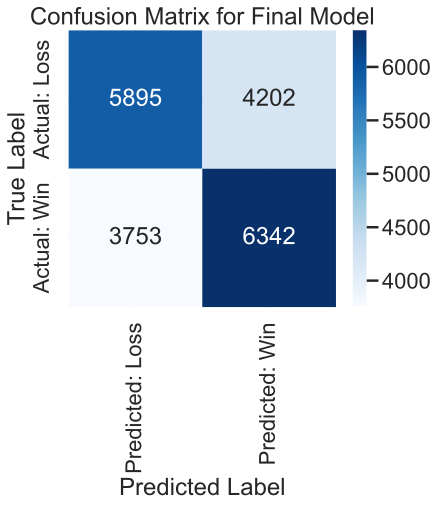

In [83]:
cm = confusion_matrix(y_test, y_pred_final)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: Loss', 'Predicted: Win'], yticklabels=['Actual: Loss', 'Actual: Win'])
plt.title('Confusion Matrix for Final Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

What can we interpret from this?

The confusion matrix provides a breakdown of our Decision Tree model’s predictions:

- **Top-left (True Negatives)**: The number of times the model correctly predicted a loss.
- **Bottom-right (True Positives)**: The number of times the model correctly predicted a win.
- **Top-right (False Positives)**: Losses incorrectly predicted as wins.
- **Bottom-left (False Negatives)**: Wins incorrectly predicted as losses.

Judging based off of this, our final model accuracy seems to be mediocre, because although the number of false positives and false negatives are lower than the number of true positive and true negatives, it is low enough. There is only a thousand-ish difference between them. We expected more. However, it is acceptable nonentheless because it is an improvement over our base model.

**Summary**:

- The best cross-validated model used `max_depth = 10`.
- **Accuracy**: 0.606, overall correctness
- **Precision**: 0.601, how often predicted wins are correct
- **Recall**: 0.628, how many actual wins were caught
- **F1-score**: 0.614, a single score balancing precision & recall

These metrics show a clear improvement over the baseline model. Accuracy has increased from 0.538 to 0.606, and all other metrics have improved as well. This suggests that the new features provided additional predictive power regarding match outcome, especially in identifying wins (higher recall and F1-score for class 1). Although the accuracy is still modest (which means there is definitley room for future improvement), these gains are evidence that suggest the new features, especially those related to vision, add a predictive value to our final model.

## **Fairness Analysis**

In this final section, we will futher investigate the potential biases of our model. More specifically, we will investigate whether our model treats teams differently based on their side selection. In other words, whether it predicts wins more accurately for teams starting on the **Blue** (Group X) side versus the **Red** (Group Y) side.

In LoL, each match is split into two opposing teams: Red and Blue. Although both sides function symmetrically in layout at a first glance, their placements actually differ in objective positioning, and vision angles. These differences can **influence gameplay and outcomes**, which is why "side selection" is often a strategic consideration in professional play. We can further visualize this by taking a look at the `side` and `position` columns in our original dataset.

In [90]:
df[['side', 'position']]

,side,position
0,Blue,top
1,Blue,jng
2,Blue,mid
...,...,...
117645,Red,sup
117646,Blue,team
117647,Red,team


In our analysis, we examine whether our model performs equitably across these two sides, or if it favors one over the other.

**We will focus on precision as our fairness metric**. Precision is especially relevant in this context because it measures the proportion of predicted wins that are actually wins. In other words, how trustworthy a "win" prediction is for each group.

In [ ]:
blue_mask = X_test['side'] == 'Blue'
red_mask = X_test['side'] == 'Red'

y_true_blue = y_test[blue_mask]
y_pred_blue = y_pred_final[blue_mask.values]

y_true_red = y_test[red_mask]
y_pred_red = y_pred_final[red_mask.values]


prec_blue = precision_score(y_true_blue, y_pred_blue)
prec_red = precision_score(y_true_red, y_pred_red)
obs_diff = prec_blue - prec_red

print(f"Precision (Blue): {prec_blue:.3f}")
print(f"Precision (Red):  {prec_red:.3f}")
print(f"Observed Difference (Blue - Red): {obs_diff:.3f}")

Precision (Blue): 0.627
Precision (Red):  0.572
Observed Difference (Blue - Red): 0.055


**Observed Disparity**:

- **Precision** (`Blue`): 0.627
- **Precision** (`Red`): 0.572
- **Observed Difference** (`Blue` − `Red`): 0.055

This slight ~5% difference suggests our model is more precise in predicting wins for Blue side teams than Red side teams.

Now, **to assess whether this difference could have arisen by chance, we ran a permutation test**. We randomly shuffled the side labels 1000 times and recalculated the precision difference each time. The resulting null distribution shows what kind of differences we'd expect if `side` had no impact on model precision.

Here is our permutation test hypotheses:

- **Null Hypothesis** (H₀): There is no difference in the model’s precision for predicting wins between Blue side teams and Red side teams.

    - In other words: Precision(Blue) == Precision(Red) 
 
- **Alternative Hypothesis** (Hₐ): There is a difference in the model’s precision between Blue side and Red side teams. 

    - In other words: Precision(Blue) == Precision(Red)

This is a two-sided test because we are open to finding a difference in either direction (i.e., either side could have higher precision).

Let's see how our observed difference of 0.055 falls in this distribution! We will use a standard significance level of 0.05.

In [91]:
side_array = X_test['side'].values
n = 1000
diffs = []

y_true_all = y_test.values
y_pred_all = y_pred_final

for _ in range(n):
    shuffled_sides = np.random.permutation(side_array)
    blue_mask_perm = shuffled_sides == 'Blue'
    red_mask_perm = shuffled_sides == 'Red'

    prec_blue_perm = precision_score(y_true_all[blue_mask_perm], y_pred_all[blue_mask_perm])
    prec_red_perm = precision_score(y_true_all[red_mask_perm], y_pred_all[red_mask_perm])
    diffs.append(prec_blue_perm - prec_red_perm)

diffs = np.array(diffs)
p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))
pass_test(p_value)


'P-value: 0.0000, reject the null hypothesis.'

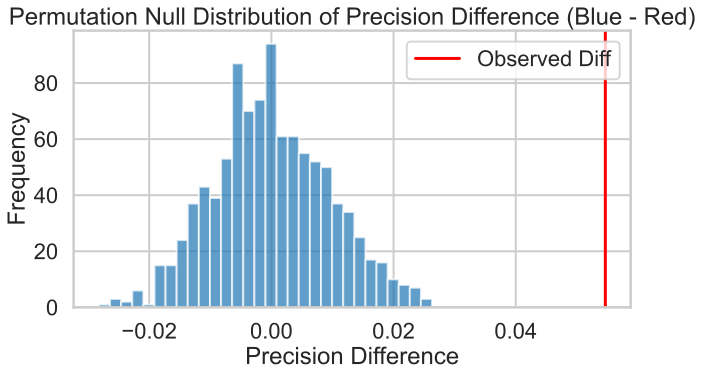

In [ ]:
plt.hist(diffs, bins=30, alpha=0.7)
plt.axvline(obs_diff, color='red', label='Observed Diff')
plt.title('Permutation Null Distribution of Precision Difference (Blue - Red)')
plt.xlabel('Precision Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Since our p-value is well below the alpha threshold of 0.05, **we reject the null hypothesis** and conclude that our model's precision is significantly different for Blue Side and Red Side. In particular, our model is more precise at predicting wins for Blue Side teams than for Red Side teams. **This suggests that our model may be unintentionally biased with towards teams depending on side selection**.

This finding raises a potential fairness concern: the model may be unintentionally biased toward teams starting on the Blue side. This could stem from:

- Systemic differences in how Blue and Red sides play (e.g. pick order advantages, objective positioning)
- Imbalanced data, if more Blue side teams win in the training set
- Feature encoding or gameplay dynamics that interact differently with side

Of course, other forms of bias may exist. For example, by league, region, or even individual players (if some are overrepresented in the data). A more comprehensive fairness exploration would be needed to evaluate these potential biases as well.

## Conclusion

In this project, we explored how League of Legends vision-related metrics, particularly wards placed per mite (wpm), relate to match outcomes in professional League of Legends games. We began by cleaning up a 2024 LoL Esports dataframe, handling missing data thoughtfully, and aggregated data in order to create a new, grouped, dataframe for further exploration.

We then used hypothesis testing to determine that wpm is significantly associated with a higher win rate, though the visual difference in distributions was subtle at a first glance. From there, we built a baseline classification model to predict match outcomes, using other gameplay features available that were related to wpm. We extended this into a final model by introducing more vision-related features, and tuning the model's hyperparameters using cross-validation and GridSearchCV.

Our final model showed modest improvement over the baseline (accuracy: 0.538 → 0.606), indicating these added features do improve predictive power. Finally, we conducted a fairness analysis and found the model is significantly more precise at predicting wins for Blue side teams than Red side, raising important questions about potential bias tied to gameplay dynamics or data imbalance.

Overall, this project gives an insight on preprocessing, statistical testing, and fairness analysis when building interpretable models in LoL esports analytics.